In [1]:
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import FrozenDict
import jax.numpy as jnp
import numpy as np

import jax
from jax import nn as jnn
from jax import random

from functools import partial

from flax import linen as nn
from flax import optim

import optax

import h5py
from fenics import *

from typing import Sequence

import matplotlib
import matplotlib.pyplot as plt

import basix
from basix import ElementFamily, CellType, LagrangeVariant

import os

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

from IPython import display

2022-03-22 18:15:06.334743: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 18:15:06.508242: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 18:15:06.511658: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 18:15:07.344564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
hwloc/li

In [2]:
def read_mesh_and_function(file_name, var_name):

    # Open solution file
    infile = XDMFFile(file_name + ".xdmf")
    infile_h5 = h5py.File(file_name + ".h5", "r")
    t_steps = len(infile_h5[var_name].keys())

    # Read in mesh
    mesh = Mesh()
    infile.read(mesh)

    # Read function
    V = FunctionSpace(mesh, "CG", 1)
    u = Function(V)
    solution = np.zeros((V.dim(), t_steps))
    for i in range(t_steps):
        infile.read_checkpoint(u, var_name, i - t_steps + 1)
        solution[:, i] = u.vector().get_local()

    # Clean up
    infile.close()
    infile_h5.close()

    return mesh, solution


nu = 0.001
A = 0.5
mesh, u_ref = read_mesh_and_function(
    "../output/burgers_1D/nu_" + str(nu) + "/FOM", "u")
u_ref = u_ref.T
V = FunctionSpace(mesh, "CG", 1)

time_steps, N = u_ref.shape
n = 20
M1 = 100
M2 = N
n_sigmas = 20

from model_definition import *

def model():
    return VAE(encoder_latents=[M1], decoder_latents=[M2], N=N, n=n, n_sigmas=n_sigmas)

In [3]:
params = model().init(random.PRNGKey(0), u_ref[0])
tx = optax.adam(0.001)
state = train_state.TrainState.create(apply_fn=model().apply,
                                      params=params,
                                      tx=tx)
CKPT_DIR = "nu_" + str(nu) + "_n_" + str(n) + "_n_sigmas_" + str(n_sigmas)
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR, target=state)
params = params.copy(restored_state.params)

2022-03-22 18:15:54.357595: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
fig_dir = "figures/"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
plt.rcParams.update({'font.size': 16})

In [6]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(6, 8))
(ax1, ax2) = fig.subplots(2, 1, sharex=True)
lines1 = ax1.plot([])
ax1.set_xlim(0, 2)
ax1.set_ylim(0.5, 2.5)
lines2 = ax2.plot(np.empty((0, 3)), np.empty((0, 3)))
ax2.set_xlim(0, 2)
ax2.set_ylim(-0.3, 0.3)

Phi_func = jax.jit(jax.jacfwd(lambda params, u: model().apply(params, u, method=VAE.decode), argnums=1))

def AnimationFunction(frame):
    if frame % 100 == 0:
        print('frame {:}'.format(frame))
    u_ref_encoded = model().apply(params, u_ref[frame], method=VAE.encode)
    Phi = Phi_func(params, u_ref_encoded)
    lines1[0].set_data((V.tabulate_dof_coordinates()[:,0], u_ref[frame]))
    lines2[0].set_data((V.tabulate_dof_coordinates()[:,0], Phi.T[0]))
    lines2[1].set_data((V.tabulate_dof_coordinates()[:,0], Phi.T[1]))
    lines2[2].set_data((V.tabulate_dof_coordinates()[:,0], Phi.T[2]))

anim = FuncAnimation(fig, AnimationFunction, frames=u_ref.shape[0], interval=15)
video = anim.to_html5_video()
with open(fig_dir + "nu_" + str(nu) + "_basis_n_" + str(n) + ".html", "w") as f:
    f.write(video)

plt.close()

frame 0
frame 0
frame 100
frame 200
frame 300
frame 400
frame 500


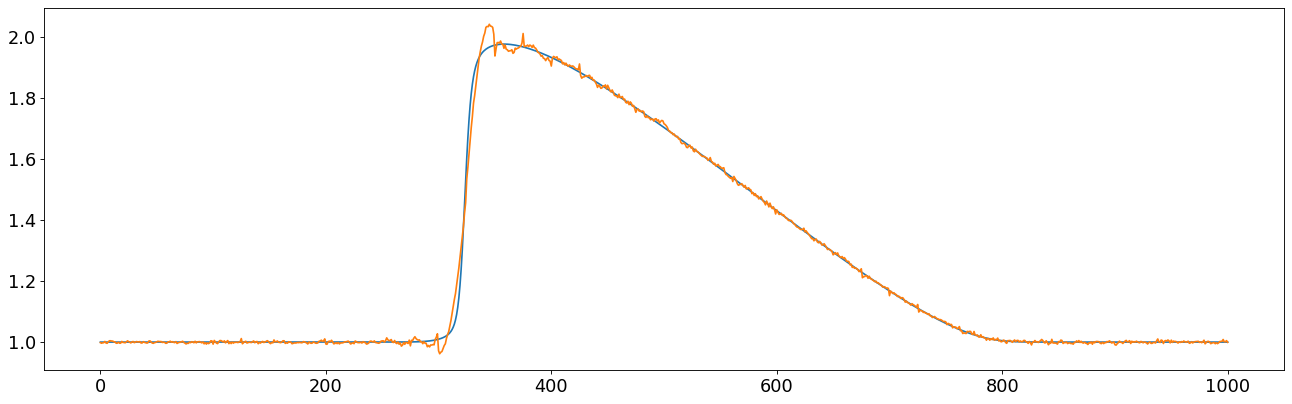

In [7]:
plt.figure(figsize=(20, 6), dpi=80)
u_peek = u_ref[400]
plt.plot(u_peek)
plt.plot(model().apply(params, u_peek))

In [8]:
t_start = 0.0
t_final = 0.5
dt = 0.001

In [9]:
nelem = mesh.num_cells()

# Per element
nqp = 2
ndof = 2
nvertex = 2
nnode = 2
ndim = 2

# Data structure to be computed per element
dof_map = np.zeros((nelem,ndof), dtype=int)
JxW = np.zeros((nelem,nqp))
grad_test = np.zeros((nelem,nqp,nnode,ndim))

lagrange = basix.create_element(ElementFamily.P, CellType.interval, 1, LagrangeVariant.equispaced)
ref_points, weights = basix.make_quadrature(CellType.interval, 2)
test, ref_grad_test = lagrange.tabulate(1, ref_points)
test = test.reshape(2,2)
ref_grad_test = ref_grad_test.reshape(2,2)

for e in range(nelem):
    cell = Cell(mesh, e)
    dof_map[e] = V.dofmap().cell_dofs(e)
    coordinates = np.array(cell.get_coordinate_dofs()).reshape(2,2)
    for qp,weight in enumerate(weights):
        J = jnp.matmul(ref_grad_test[qp], coordinates)
        detJ = jnp.sqrt(jnp.dot(J, J))
        JxW[e][qp] = detJ*weight
        grad_test[e][qp] = jnp.vstack((ref_grad_test[qp]/detJ, jnp.zeros((1,2)))).T

dof_map = jnp.array(dof_map)
JxW = jnp.array(JxW)
grad_test = jnp.array(grad_test)

In [10]:
def local_residual(dofs,JxW,test,grad_test,ut,ut_old,dt):
    local_re = jnp.zeros((N,))
    for i in range(nnode):
        r = 0
        for qp in range(nqp):
            u = jnp.dot(test[qp], ut[dofs])
            u_old = jnp.dot(test[qp], ut_old[dofs])
            grad_u = jnp.matmul(ut[dofs], grad_test[qp])
            r = r + (test[qp][i]*(u-u_old)/dt+nu*jnp.dot(grad_test[qp][i],grad_u)+test[qp][i]*grad_u[0]*u) * JxW[qp]
        local_re = local_re.at[dofs[i]].set(r)
    return local_re

In [11]:
def objective(ur, ur_old, dt, params):
    ut = model().apply(params, ur, method=VAE.decode)
    ut_old = model().apply(params, ur_old, method=VAE.decode)
    local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old,dt)
    r = jnp.sum(local_res,axis=0)
    return 0.5*jnp.dot(r,r)

residual = jax.jit(jax.value_and_grad(objective))

jacobian = jax.jit(jax.jacfwd(jax.grad(objective)))

In [12]:
class Divergence(Exception):
    pass

def solve(u, u_old, dt, nl_max_its, RTOL, ATOL):
    def converged(r, r0):
        if jnp.linalg.norm(r) < ATOL:
            return True
        if jnp.linalg.norm(r) < RTOL * jnp.linalg.norm(r0):
            return True
        return False

    obj, r = residual(u, u_old, dt, params)
    r0 = r
    for itr in range(nl_max_its):
        print('Itr = {:}, |R| = {:.3E}, objective = {:.3E}'.format(itr, jnp.linalg.norm(r), obj))

        if converged(r, r0):
            return u400
        
        J = jacobian(u, u_old, dt, params)

        du = - jnp.linalg.solve(J, r)
        u = u + du
        obj, r = residual(u, u_old, dt, params)

    raise Divergence

def solve_step(i, t, u, dt, nl_max_its=10, RTOL=1e-6, ATOL=1e-8):
    try:
        i = i + 1
        t = t + dt
        u_old = u
        print('\nstep = {}, t = {}'.format(i, t))
        u = solve(u, u_old, dt, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
    except Divergence:
        display.clear_output(wait=True)
        print('solve failed, cut dt')
        i = i - 1
        t = t - dt
        u = u_old
        i, t, u = solve_step(i, t, u, dt/2, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
        i, t, u = solve_step(i, t, u, dt/2, nl_max_its=nl_max_its, RTOL=RTOL, ATOL=ATOL)
    return i, t, u

In [13]:
u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = model().apply(params, u0.vector().get_local(), method=VAE.encode)
ur = ur0

def residual_helper(ur, ur_old, params):
    return np.array(residual(ur, ur_old, params))

def jacobian_helper(ur, ur_old, params):
    return np.array(jacobian(ur, ur_old, params))


i = 0
t = t_start
ts = []
u_approx = []
while t < t_final:
    i, t, ur = solve_step(i, t, ur, dt, nl_max_its=20, ATOL=1e-9)
    if i % 2 == 0:
        display.clear_output(wait=True)
    u_approx.append(model().apply(params, ur, method=VAE.decode))
u_approx = np.array(u_approx)


step = 499, t = 0.4990000000000004
Itr = 0, |R| = 6.909E-01, objective = 1.237E-01
Itr = 1, |R| = 2.606E-02, objective = 8.953E-02
Itr = 2, |R| = 4.513E-05, objective = 8.948E-02
Itr = 3, |R| = 2.303E-10, objective = 8.948E-02

step = 500, t = 0.5000000000000003
Itr = 0, |R| = 6.637E-01, objective = 1.340E-01
Itr = 1, |R| = 1.724E-02, objective = 1.029E-01
Itr = 2, |R| = 1.734E-05, objective = 1.029E-01
Itr = 3, |R| = 3.012E-11, objective = 1.029E-01


In [15]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref.T, vmin=1, vmax=2, cmap='jet')
cb_ref = fig.colorbar(im)
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xticks(np.linspace(0, time_steps, 3))
ax.set_xticklabels(np.linspace(t_start, t_final, 3))
ytick_loc = np.linspace(0, V.dim() - 1, 3).astype(int)
ax.set_yticks(ytick_loc)
ax.set_yticklabels(V.tabulate_dof_coordinates()[ytick_loc, 0])
ax.set_aspect("auto")
plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_ref.png")
plt.close()

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(u_approx.T, vmin=1, vmax=2, cmap='jet')
cb = fig.colorbar(im)
cb.set_ticks(cb_ref.get_ticks())
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xticks(np.linspace(0, u_approx.shape[0], 3))
ax.set_xticklabels(np.linspace(t_start, t_final, 3))
ytick_loc = np.linspace(0, V.dim() - 1, 3).astype(int)
ax.set_yticks(ytick_loc)
ax.set_yticklabels(V.tabulate_dof_coordinates()[ytick_loc, 0])
ax.set_aspect("auto")
plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_n_" + str(n) + ".png")
plt.close()

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(np.abs(u_approx - u_ref[1:]).T, norm=matplotlib.colors.LogNorm())
fig.colorbar(im)
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.set_xticks(np.linspace(0, u_approx.shape[0], 3))
ax.set_xticklabels(np.linspace(t_start, t_final, 3))
ytick_loc = np.linspace(0, V.dim() - 1, 3).astype(int)
ax.set_yticks(ytick_loc)
ax.set_yticklabels(V.tabulate_dof_coordinates()[ytick_loc, 0])
ax.set_aspect("auto")
plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_err_n_" + str(n) + ".png")
plt.close()